In [22]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import pandas as pd
import gensim.downloader as api
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer 
import gensim
import numpy as np


#### Load Data

In [367]:
speeches = pd.read_csv("../../data/EUCommissionSpeeches/speeches_unique_eng.csv", sep=";", index_col=[0])
speeches

,speech_id,speaker,speaker_id,date,year,title,meta_tags,link,speech,lang
0,SPEECH/19/7325,Phil Hogan,184,14 October 2019,2019,Side Event of the Global Network Against Food ...,Speech|14 October 2019|Brussels,https://ec.europa.eu/commission/presscorner/de...,"Dear David, Dear Dongyu, Distinguished Guests,...",en
1,SPEECH/19/7322,Phil Hogan,184,14 October 2019,2019,Intervention for the Plenary on SOFI Launch (R...,Speech|14 October 2019|Brussels,https://ec.europa.eu/commission/presscorner/de...,"Distinguished Guests, Ladies and Gentlemen, Fr...",en
2,SPEECH/19/7324,Phil Hogan,184,14 October 2019,2019,"Signature 9 million euros contract (Rome, 14/1...",Speech|14 October 2019|Brussels,https://ec.europa.eu/commission/presscorner/de...,"Ladies and Gentlemen, Dear colleagues, Dear Qu...",en
3,SPEECH/19/7277,Phil Hogan,184,30 September 2019,2019,Trade For Her – Empowering women through inter...,Speech|30 September 2019|Brussels,https://ec.europa.eu/commission/presscorner/de...,"Ladies and Gentlemen, Dear Cecilia, First, let...",en
4,SPEECH/19/7309,Phil Hogan,184,26 September 2019,2019,Integrated National Financing Frameworks – a t...,Speech|26 September 2019|Brussels,https://ec.europa.eu/commission/presscorner/de...,"Your Excellencies, Distinguished Guests, Ladie...",en
...,...,...,...,...,...,...,...,...,...,...
2140,SPEECH/15/4380,Frans Timmermans,162,11 February 2015,2015,Préparation du Conseil européen informel du 12...,Speech|11 February 2015|Strasbourg,https://ec.europa.eu/commission/presscorner/de...,"Discours de Frans Timmermans, Premier Vice-Pré...",fr
2141,SPEECH/14/1701,Frans Timmermans,162,13 November 2014,2014,A New Chapter for Cross-border Criminal Justic...,Speech|13 November 2014,https://ec.europa.eu/commission/presscorner/de...,Conference on the competence of the European C...,en
2144,SPEECH/22/6949,Adina Vălean,997,15 November 2022,2022,Press remarks by Commissioner Adina Vălean fol...,Speech|15 November 2022|Brussels,https://ec.europa.eu/commission/presscorner/de...,"Today, we adopted a joint statement on the clo...",en
2148,SPEECH/22/6144,Olivér Várhelyi,998,12 October 2022,2022,Opening remarks by Commissioner Olivér Várhely...,Speech|12 October 2022|Brussels,https://ec.europa.eu/commission/presscorner/de...,"Good afternoon, ladies and gentlemen. Welcome ...",en


#### Some Preprocessing

In [368]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric, strip_multiple_whitespaces, strip_short, remove_stopwords
from langdetect import detect

CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]

speeches = speeches[speeches['lang'] == 'en']

speeches['speech_cleaned'] = speeches.speech.apply(lambda x: " ".join(preprocess_string(str(x), CUSTOM_FILTERS)))



#### Calculate document embeddings

In [535]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(filters='–!"#$%&”“()*+,-.‘/:;…<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(speeches.speech_cleaned)

embedding_dim = 300

tokenized_documents=tokenizer.texts_to_sequences(speeches.speech_cleaned)
tokenized_paded_documents=pad_sequences(tokenized_documents,maxlen=embedding_dim,padding='post')

vocab_size=len(tokenizer.word_index)+1

In [9]:
google_news_vectors = gensim.downloader.load('word2vec-google-news-300')

In [10]:
google_news_vectors.most_similar('digital')

[('digitial', 0.676041305065155),
 ('Digital', 0.6294012069702148),
 ('digital_imaging', 0.6084018349647522),
 ('digitally', 0.5993913412094116),
 ('digitization', 0.5817912220954895),
 ('highdefinition', 0.5789847373962402),
 ('multimedia', 0.5721380710601807),
 ('For_VUKUNET_logos', 0.5558314919471741),
 ('HandHeld_Entertainment_NASDAQ_ZVUE', 0.5478215217590332),
 ('mpx', 0.5467243194580078)]

In [576]:
# creating embedding matrix, every row is a vector representation from the vocabulary indexed by the tokenizer index. 
embedding_matrix_google=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if word in google_news_vectors:
        embedding_matrix_google[i]=google_news_vectors[word]
# creating document-word embeddings
document_word_embeddings_google=np.zeros((len(tokenized_paded_documents),embedding_dim,300))
for i in range(len(tokenized_paded_documents)):
    for j in range(len(tokenized_paded_documents[0])):
        document_word_embeddings_google[i][j]=embedding_matrix_google[tokenized_paded_documents[i][j]]
document_word_embeddings_google.shape

(1787, 300, 300)

In [539]:
sum([word in google_news_vectors for word in tokenizer.word_index])/len(tokenizer.word_index)

0.744179534362749

In [540]:
document_word_embeddings_google = np.mean(document_word_embeddings_google, axis=1)
document_word_embeddings_google.shape

(1787, 300)

#### Calculating Centroids from dictionaries

##### Load data

In [3]:
import joblib

In [4]:

cognition = joblib.load('C:/Users/Bened/Documents/Git/Emotionality-in-Political-Speech-of-the-EU-Commission/data/emotion_dicts/dictionary_cognition.pkl')
affect = joblib.load('C:/Users/Bened/Documents/Git/Emotionality-in-Political-Speech-of-the-EU-Commission/data/emotion_dicts/dictionary_affect.pkl')

##### Calculate avg embedding vectors

In [11]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# stem google vector tokens to match with the stemmed dictionary words from LIWC
stemmed_google_vectors = {stemmer.stem(tok): google_news_vectors[tok] for tok in google_news_vectors.key_to_index}

In [12]:
# check the coverage of google embeddings with LIWC words
sum([w in stemmed_google_vectors for w in affect])/len(affect)

1.0

In [543]:
sum([w in stemmed_google_vectors for w in cognition])/len(cognition)

1.0

In [13]:
len(cognition)

169

In [14]:
vecs = [stemmed_google_vectors[w] for w in cognition if w in stemmed_google_vectors]
vecs = [v for v in vecs if len(v) > 0]
# calculate average of all 300 dim embeddings of each words along axis 0 to get one 300dim embedding representing 'cognitive words'
cognition_centroid = np.mean(vecs, axis=0)


In [545]:
vecs = [stemmed_google_vectors[w] for w in affect if w in stemmed_google_vectors]
vecs = [v for v in vecs if len(v) > 0]
affect_centroid = np.mean(vecs, axis=0)

#### Calculating Emtionality scores for each speech

In [246]:
from numpy.linalg import norm


In [360]:
def cos_sim(A, B):
    return np.dot(A,B)/(norm(A)*norm(B))

def calc_emotionality_score(doc_emb):
    return (cos_sim(doc_emb, affect_centroid) + 1)/(cos_sim(doc_emb, cognition_centroid) + 1)

def calc_affect_score(doc_emb):
    return cos_sim(doc_emb, affect_centroid)

def calc_cognition_score(doc_emb):
    return cos_sim(doc_emb, cognition_centroid)


In [546]:
speeches['emotion_score'] = [calc_emotionality_score(d) for d in document_word_embeddings_google]
speeches['affect_score'] = [calc_affect_score(d) for d in document_word_embeddings_google]
speeches['cognition_score'] = [calc_cognition_score(d) for d in document_word_embeddings_google]



(array([  2.,  36., 169., 321., 354., 353., 209., 138.,  76.,  41.,  37.,
         15.,  10.,   5.,   8.,   7.,   3.,   1.,   0.,   2.]),
 array([0.10075028, 0.12486622, 0.14898215, 0.17309808, 0.19721402,
        0.22132995, 0.24544588, 0.26956182, 0.29367775, 0.31779368,
        0.34190962, 0.36602555, 0.39014148, 0.41425742, 0.43837335,
        0.46248928, 0.48660522, 0.51072115, 0.53483708, 0.55895301,
        0.58306895]),
 <BarContainer object of 20 artists>)

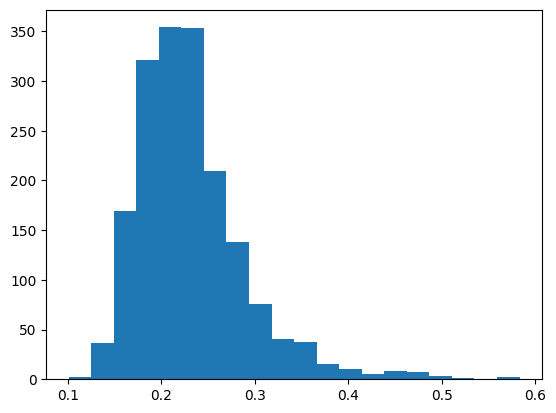

In [547]:
import matplotlib.pyplot as plt

plt.hist(speeches['affect_score'], bins = 20)

(array([  2.,  36., 169., 321., 354., 353., 209., 138.,  76.,  41.,  37.,
         15.,  10.,   5.,   8.,   7.,   3.,   1.,   0.,   2.]),
 array([0.10075028, 0.12486622, 0.14898215, 0.17309808, 0.19721402,
        0.22132995, 0.24544588, 0.26956182, 0.29367775, 0.31779368,
        0.34190962, 0.36602555, 0.39014148, 0.41425742, 0.43837335,
        0.46248928, 0.48660522, 0.51072115, 0.53483708, 0.55895301,
        0.58306895]),
 <BarContainer object of 20 artists>)

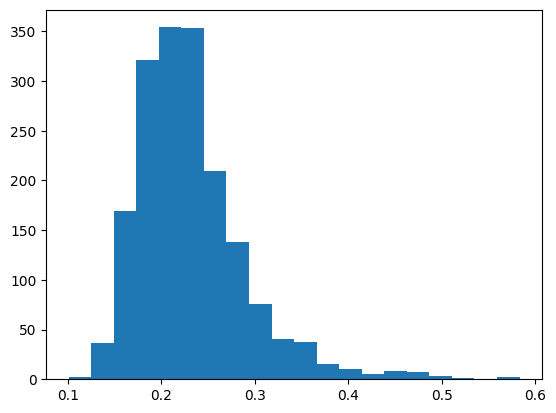

In [548]:
import matplotlib.pyplot as plt

plt.hist(speeches['affect_score'], bins = 20)

#### Own Embeddings

In [549]:
# using same filters as with the google embeddings
docs = [word_tokenize(d) for d in tokenizer.sequences_to_texts(tokenized_documents)]
tokenized_paded_documents=pad_sequences(tokenized_documents,maxlen=300,padding='post')


In [ ]:
# alternative 2: raw tokenization
docs = [word_tokenize(d) for d in speeches.speech_cleaned]

In [550]:
word2vec_own = Word2Vec(sentences=docs, vector_size=300, window=8, min_count=3, workers=4, epochs=10)
own = word2vec_own.wv



In [551]:
tokenized_paded_documents.shape

(1787, 300)

In [570]:
# creating embedding matrix, every row is a vector representation from the vocabulary indexed by the tokenizer index. 
embedding_matrix_own=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if word in own:
        embedding_matrix_own[i]=own[word]
# creating document-word embeddings
document_embeddings_own=np.zeros((len(tokenized_paded_documents),300,300))
for i in range(len(tokenized_paded_documents)):
    for j in range(len(tokenized_paded_documents[0])):
        document_embeddings_own[i][j]=embedding_matrix_own[tokenized_paded_documents[i][j]]
document_embeddings_own.shape

(1787, 300, 300)

In [553]:
sum([word in own for word in own.key_to_index])/len(own.key_to_index)

1.0

In [554]:
document_embeddings_own_mean = np.mean(document_embeddings_own, axis=1)
document_embeddings_own_mean.shape

(1787, 300)

##### Check emotion dicts are contained in own embeddings

In [555]:
own.most_similar('digital')

[('digitalisation', 0.5837000608444214),
 ('modernisation', 0.50633704662323),
 ('technological', 0.45326265692710876),
 ('artificial', 0.4338042438030243),
 ('modern', 0.4319761395454407),
 ('industrial', 0.4313698709011078),
 ('twin', 0.4312397241592407),
 ('connectivity', 0.4283887445926666),
 ('entrepreneurial', 0.4269011318683624),
 ('disruptive', 0.42605891823768616)]

In [558]:
stemmed_own = { stemmer.stem(key): own[key] for key in own.key_to_index }



In [559]:
sum(stemmed_own['europ'] == own['europe'])/len(stemmed_own['europ'] == own['europe'])

1.0

In [560]:
sum([w in stemmed_own for w in affect])/len(affect)

0.3624801271860095

In [561]:
sum([w in stemmed_own for w in cognition])/len(cognition)

0.6272189349112426

In [562]:
vecs = [stemmed_own[w] for w in cognition if w in stemmed_own]
vecs = [v for v in vecs if len(v) > 0]
cognition_centroid = np.mean(vecs, axis=0)

In [563]:
vecs = [stemmed_own[w] for w in affect if w in stemmed_own]
vecs = [v for v in vecs if len(v) > 0]
affect_centroid = np.mean(vecs, axis=0)

In [564]:
speeches['emotion_score_own_embedding'] = [calc_emotionality_score(d) for d in document_embeddings_own_mean]
speeches['affect_score_own_embedding'] = [calc_affect_score(d) for d in document_embeddings_own_mean]
speeches['cognition_score_own_embedding'] = [calc_cognition_score(d) for d in document_embeddings_own_mean]

(array([ 22., 113., 180., 217., 209., 227., 218., 149., 154.,  81.,  66.,
         43.,  23.,  24.,  20.,  11.,  10.,  10.,   5.,   5.]),
 array([-0.29775855, -0.24684082, -0.19592309, -0.14500536, -0.09408762,
        -0.04316989,  0.00774784,  0.05866557,  0.10958331,  0.16050104,
         0.21141877,  0.2623365 ,  0.31325424,  0.36417197,  0.4150897 ,
         0.46600743,  0.51692517,  0.5678429 ,  0.61876063,  0.66967836,
         0.7205961 ]),
 <BarContainer object of 20 artists>)

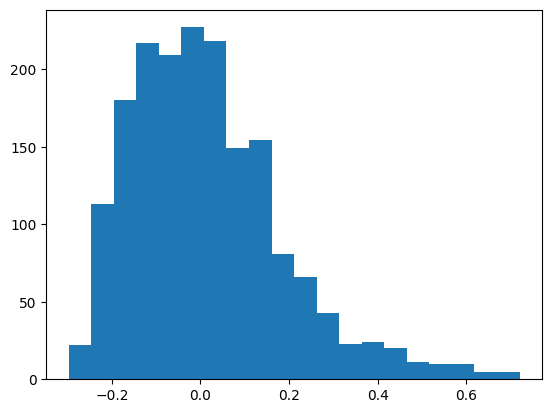

In [565]:

plt.hist(speeches['affect_score_own_embedding'], bins = 20)

#### Using TFIDF Weighting

##### Own Embedding

In [566]:
tfidf = tokenizer.texts_to_matrix(speeches.speech_cleaned, mode="tfidf")
tfidf.shape

(1787, 24999)

In [567]:
# Check (cannot be 0)
tfidf[0][tokenizer.word_index['david']]

4.244641672733369

In [523]:
len(words)

25327

In [571]:
embedding_matrix_own.shape

(24999, 300)

In [572]:
document_embeddings_weighted=np.zeros((len(tokenized_paded_documents),300))
words=list(tokenizer.word_index.keys())
for i in range(len(document_embeddings_own)):
    for j in range(len(words)):
        document_embeddings_weighted[i]+=embedding_matrix_own[tokenizer.word_index[words[j]]]*tfidf[i][j]
print(document_embeddings_weighted.shape)

(1787, 300)


In [574]:
speeches['emotion_score_own_embedding_tfidf'] = [calc_emotionality_score(d) for d in document_embeddings_weighted]
speeches['affect_score_own_embedding_tfidf'] = [calc_affect_score(d) for d in document_embeddings_weighted]
speeches['cognition_score_own_embedding_tfidf'] = [calc_cognition_score(d) for d in document_embeddings_weighted]

##### Google embedding

In [577]:
document_embeddings_google_weighted=np.zeros((len(tokenized_paded_documents),300))
words=list(tokenizer.word_index.keys())
for i in range(len(document_embeddings_own)):
    for j in range(len(words)):
        document_embeddings_google_weighted[i]+=embedding_matrix_google[tokenizer.word_index[words[j]]]*tfidf[i][j]
print(document_embeddings_google_weighted.shape)

(1787, 300)


In [578]:
speeches['emotion_score_tfidf'] = [calc_emotionality_score(d) for d in document_embeddings_weighted]
speeches['affect_score_tfidf'] = [calc_affect_score(d) for d in document_embeddings_weighted]
speeches['cognition_score_tfidf'] = [calc_cognition_score(d) for d in document_embeddings_weighted]

In [580]:
speeches.to_csv("../../data/speeches_w_emotion_score.csv", sep=";")